In [323]:
import pandas as pd
import numpy as np
from functools import reduce
import pytz
import missingno as msno
import altair as alt


[Shift time for TimeCreatedSystemTime to UTC](#timeshift)
[Join machines to events](#machines_events)


In [324]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')

In [325]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [326]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [327]:
def get_compare_chart(in_data, in_col, in_title):
    """
    # Visualize codes by EventName in df_win['EventName'].

    :param in_data:
    :param in_col:
    :param in_title:
    :return:
    """

    count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0: 'count'})
    # Sort order for chart
    count_df2.sort_values('count', ascending=False, inplace=True)
    sort_order = [val for val in count_df2[in_col].unique()]
    out_chart = alt.Chart(count_df2).mark_bar().encode(
        x=alt.X('count:Q'),
        y=alt.Y(in_col + ':N', sort=sort_order),
        tooltip='count:Q'
    ).properties(title=in_title)
    return out_chart


def show_bar_for_win_event(eventname_list, in_df, visualize_attr):
    for eventname in eventname_list:
        current_df = in_df[in_df['EventName'] == eventname]
        out_chart = get_compare_chart(current_df, visualize_attr,
                                      f'Counts of {visualize_attr} types for {eventname} events')
        yield out_chart

In [328]:
# Get the event names
eventnames = df_win['EventName'].unique()
charts = show_bar_for_win_event(eventnames, df_win, 'ProblemSignatureP3')

In [329]:
# current_chart = next(charts)
# current_chart

In [330]:
eventnames

array(['crashpad_exp', 'APPCRASH', 'AppHangB1', 'MoAppHang', 'BEX64',
       'MoAppCrash', 'MoBEX', 'CLR20r3', 'BEX', 'AppHangXProcB1',
       'LiveKernelEvent', 'MoAppHangXProc', 'POFContextAppCrash',
       'ServiceHang', 'CbsPackageServicingFailure2',
       'CriticalProcessFault2', 'crashpad_jserror', 'WUDFVerifierFailure'],
      dtype=object)

In [331]:
print(df_win['ProblemSignatureP3'].str.contains('.dll').sum())
print(len(df_win))

1569
9836



-  crashpad_exp has only .dll EventItems
-  APPCRASH has 1 .dll and many alphanumeric codes
-  AppHangB1 has only hexadecimal codes
-  MoAppHang has IP-style codes
-  BEX64 has only alphanumeric codes
-  MoAppCrash has IP-style codes
-  MoBEX has IP-style codes
-  CLR20r3 has hexadecimal codes
-  BEX has hexadecimal codes
-  AppHangXProcB1 has hexadecimal codes
-  LiveKernelEvent has single numbers, single letters, and (many) alphanumeric codes
-  MoAppHangXProc events has 2 IP-style codes
-  POFContextAppCrash has IP-style codes
-  ServiceHang has IP-style codes
-  CbsPackageServicingFailure2 has IP-style codes
-  CriticalProcessFault2 has 1 alphanumeric code and 1 00000000 code
-  crashpad_jserror has webui-pdf code
-  WUDFVerifierFailure has 'Driver 'code


In [332]:
# COALESCE() in order: https://www.statology.org/pandas-coalesce/
df_win['Combined_dll'] = df_win[['ProblemSignatureP3', 'ProblemSignatureP6']].bfill(axis=1).iloc[:, 0]
df_win['Combined_dll'] = df_win['Combined_dll'].apply(lambda x: x if '.dll' in str(x) else np.nan)
df_win.drop(columns=['ProblemSignatureP3', 'ProblemSignatureP6'], inplace=True)

In [333]:
df_app.rename(
    columns={
        'FaultingApplicationName':'Combined_Application',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'FaultingProcessId':'Combined_ProcessID',
        'ReportId':'Combined_ReportID',
        'FaultingApplicationStartTime':'Combined_StartTime',
        'FaultingModuleName':'Combined_dll'
    },
    inplace=True
)

df_win.rename(
    columns={
        'ProblemSignatureP1_Application':'Combined_Application',
        'ProblemSignatureP2_AppVersion':'Combined_Version',
        'ProblemSignatureP7_ExceptionCode':'Combined_Exception',
        'ReportID':'Combined_ReportID',
        'CabGuid':'CabGUID'
    },
    inplace=True
)

df_hang.rename(
    columns={
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'Program':'Combined_Application',
        'ProgramVersion':'Combined_Version',
        'ProcessID':'Combined_ProcessID',
        'ReportID':'Combined_ReportID',
        'StartTime':'Combined_StartTime'
    },
    inplace=True
)

In [334]:
events = pd.concat([df_app, df_win, df_hang])
events.reset_index(inplace=True)
events.dropna(axis=1, how='all', inplace=True) # Dropping columns with nothing in them.
# msno.matrix(events.iloc[:, 20:], labels=True, fontsize=8)

In [335]:
len(events)

318796


<a id="machines_events"></a>
# Join events with machines.


In [336]:
machines = pd.read_parquet('../do_not_commit/Datasets/Persist_System_DISC.pq')

In [337]:
# msno.matrix(incs, labels=True, fontsize=8)

In [338]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [339]:
# Join machine name ('Name0') to events by internal date and ClientItemKey (a different, but similar ID for a machine).
# Because events is left, every row will have a TimeCreatedSystemTime.
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'], how='left')

In [340]:
# Convert the TimeCreatedSystemTime CST column from Datetime to a date datatype (formatted like YYYY-MM-DD).
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

In [341]:
# msno.matrix(machines_events, labels=True, fontsize=8)

In [342]:
# Convert local time values to Central.
def convert_to_cst(df:pd.DataFrame, utc_column_name:str, cst_column_name:str):
    """
    Create a new column in the events dataframe that converts the TimeCreatedSystemTime from UTC to CST.
    (this is necessary because RWB_EFFECTIVE_DATE is in CST)
    """

    # Make sure the UTC column is in datetime format
    df[utc_column_name] = pd.to_datetime(df[utc_column_name])

    # Convert to UTC timezone
    utc_timezone = pytz.timezone('UTC')
    df[utc_column_name] = df[utc_column_name].dt.tz_localize(utc_timezone)

    # Convert to Central Standard Time (CST) timezone
    cst_timezone = pytz.timezone('America/Chicago')
    df[cst_column_name] = df[utc_column_name].dt.tz_convert(cst_timezone)

    # Drop the original UTC column if desired (optional)
    # df.drop(columns=[utc_column_name], inplace=True)

    return df

In [343]:
machines_events = convert_to_cst(machines_events, utc_column_name='TimeCreatedSystemTime', cst_column_name='CreatedSystemTime_CST')
machines_events[['TimeCreatedSystemTime', 'CreatedSystemTime_CST']].sample(5) # Check all times are -05:00 or -06:00 from UTC (Daylight Savings Time).

,TimeCreatedSystemTime,CreatedSystemTime_CST
78154,2023-02-17 15:25:45.087000+00:00,2023-02-17 09:25:45.087000-06:00
75440,2023-02-24 15:56:49.313000+00:00,2023-02-24 09:56:49.313000-06:00
223257,2023-05-12 20:43:11.260000+00:00,2023-05-12 15:43:11.260000-05:00
111639,2023-01-31 14:19:44.390000+00:00,2023-01-31 08:19:44.390000-06:00
146781,2023-01-08 06:00:12.657000+00:00,2023-01-08 00:00:12.657000-06:00


In [344]:
# Convert the TimeCreatedSystemTime CST column from Datetime to a date datatype (formatted like YYYY-MM-DD).
machines_events['CreatedSystemTime_CST_formatted'] = machines_events['CreatedSystemTime_CST'].dt.strftime('%Y-%m-%d')
machines_events['CreatedSystemTime_CST_formatted'][0]

'2023-04-10'

In [345]:
type(pd.to_datetime('2023-07-23 00:01:00').date())

datetime.date


# Join Boot events with machines separately.


In [346]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

1593485


In [347]:
df_boot['error_type'] = 'Boot'

In [348]:
# What columns do all four event types have in common?
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

array(['ClientItemKey', 'ID', 'RWB_CREATE_TIMESTAMP',
       'RWB_EFFECTIVE_DATE', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'SchemaVersion', 'error_type'], dtype=object)

In [349]:
df_boot.rename(
    columns={
        'BootId':'BootID',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'ReportId':'ReportID'
    },
    inplace=True
)

In [350]:
# Needs to be a str to join later w/ 'opened_at_formatted'.
# BootID is synonymous with 'TimeCreatedSystemTime'
# since it is the time on the machine when the boot event occurred.
df_boot['BootID_formatted'] = df_boot['BootID'].dt.strftime('%Y-%m-%d')

In [351]:
# Join machine name to boot events, similar to other section.
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])


# Join machines and events with INCs.


In [352]:
# From blob storage:
# incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_INC_20230730.csv', low_memory=False)

In [353]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')

In [354]:
# Join INCs to events on:
# 1. Machine name, and
# 2. The event and the INC both occurred on the same day, using %Y-%m-%d format (YYYY-MM-DD).
incs_merged = machines_events.merge(incs, left_on=['Name0', 'CreatedSystemTime_CST_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')
print(len(incs_merged))

320374


In [355]:
# Drop columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)

In [356]:
# msno.matrix(incs_merged, labels=True, fontsize=7)

In [357]:
# Should be many more. Why only still 4,000?
print(len(incs), "INC rows originally")
print("Now", incs_merged['number'].notnull().sum())

6104 INC rows originally
Now 5134



#### Remove INCs assc. w/ events *after* the INC was already filed.


In [358]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'CreatedSystemTime_CST_formatted',
    'CreatedSystemTime_CST',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    # 'FaultingApplicationName',
    # 'FaultingModuleName',
    'short_description_NER'
]]

,CreatedSystemTime_CST_formatted,CreatedSystemTime_CST,opened_at,opened_at_formatted,Name0,configuration_item,number,short_description_NER
74,2023-04-10,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
75,2023-04-10,2023-04-10 15:23:56.900000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
269500,2023-04-10,2023-04-10 12:35:27.050000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death


In [359]:
incs_merged['opened_at_cst_not_utc'] = incs_merged['opened_at'].dt.tz_localize('US/Central')

In [360]:
print("CreatedSystemTime_CST:", incs_merged.loc[74, 'CreatedSystemTime_CST'])
print("INC file time CST:    ", incs_merged.loc[74, 'opened_at_cst_not_utc'])
print("CreatedCST-opened_at: ", incs_merged.loc[74, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_cst_not_utc'])
# This event happened before the INC was filed, at 13:28 UTC vs 16:20 UTC (2h 52m):

CreatedSystemTime_CST: 2023-04-10 08:28:18.740000-05:00
INC file time CST:     2023-04-10 11:20:00-05:00
CreatedCST-opened_at:  -1 days +21:08:18.740000


In [361]:
print("CreatedSystemTime_CST:", incs_merged.loc[75, 'CreatedSystemTime_CST'])
print("INC file time CST:    ", incs_merged.loc[75, 'opened_at_cst_not_utc'])
print("CreatedCST-opened_at: ", incs_merged.loc[75, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_cst_not_utc'])
# This event happened after the INC was filed, at 20:23 UTC vs 16:20 UTC (4h 3m):

CreatedSystemTime_CST: 2023-04-10 15:23:56.900000-05:00
INC file time CST:     2023-04-10 11:20:00-05:00
CreatedCST-opened_at:  0 days 04:03:56.900000


In [362]:
'opened_at_formatted' in incs.columns

True

In [363]:
# Delete INCs across rows when the event occurs before the INC on the same day.
mask = incs_merged['CreatedSystemTime_CST'] >= incs_merged['opened_at_cst_not_utc']
columns_to_set_none = incs.columns
incs_merged.loc[mask, columns_to_set_none] = None

# Looks like no 'CreatedSystemTime_CST value is > 'opened_at'.
incs_merged[incs_merged['number'].notnull()][['CreatedSystemTime_CST', 'opened_at', 'number']]

,CreatedSystemTime_CST,opened_at,number
74,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,INC0515837
502,2023-04-10 07:47:01.750000-05:00,2023-04-10 20:43:00,INC0516099
570,2023-04-10 07:29:33.643000-05:00,2023-04-10 17:39:00,INC0516019
571,2023-04-10 07:51:04.520000-05:00,2023-04-10 17:39:00,INC0516019
572,2023-04-10 10:59:19.490000-05:00,2023-04-10 17:39:00,INC0516019
...,...,...,...
320202,2023-04-11 10:28:02.510000-05:00,2023-04-11 15:52:00,INC0516309
320346,2023-04-13 04:29:30.073000-05:00,2023-04-13 11:37:00,INC0516805
320347,2023-04-13 05:25:58.367000-05:00,2023-04-13 11:37:00,INC0516805
320348,2023-04-13 05:26:29.357000-05:00,2023-04-13 11:37:00,INC0516805


In [364]:
# Check to make sure. Positive = delete. Negative = keep.
(incs_merged['CreatedSystemTime_CST'] - incs_merged['opened_at_cst_not_utc']).dropna()

74       -1 days +21:08:18.740000
75         0 days 04:03:56.900000
502      -1 days +11:04:01.750000
570      -1 days +13:50:33.643000
571      -1 days +14:12:04.520000
                   ...           
320202   -1 days +18:36:02.510000
320346   -1 days +16:52:30.073000
320347   -1 days +17:48:58.367000
320348   -1 days +17:49:29.357000
320349   -1 days +19:47:37.237000
Length: 5134, dtype: timedelta64[ns]

In [365]:
# Timedelta of -1 days (24h) + 16:04 = 8h 04m difference in true time.
incs_merged.loc[502, ['CreatedSystemTime_CST', 'opened_at_cst_not_utc']]

CreatedSystemTime_CST    2023-04-10 07:47:01.750000-05:00
opened_at_utc                   2023-04-10 20:43:00-05:00
Name: 502, dtype: object


# Join machines and boot events with INCs separately.


In [366]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootID_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [367]:
print(incs_boot['number'].notnull().sum(), "Boot INCs")

7154 Boot INCs


In [368]:
# Dropping columns with nothing in them.
incs_boot.dropna(axis=1, how='all', inplace=True)

In [369]:
# How many multiple INCs were filed on the same day for a given machine?
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]

0


Series([], dtype: int64)

In [370]:
incs_boot[incs_boot['number'].notnull()]

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,is_server,short_description_NER,configuration_item,calling_user_id,opened_at_date,machine_user_test,opened_at_formatted,count,dup,group_index_orig
86,949656,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
87,949657,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
88,949659,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
89,949655,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,3,16792948,2023-02-01 09:22:37.737,0,13514,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
90,949660,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,3,16792948,2023-02-01 09:22:37.737,0,11379,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527830,1691933,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849976,3,16809497,2023-07-04 09:13:57.197,0,17795,...,0.0,Thomson One / Start menu unresponsive in Citrix,ECL-L-U32327,1456.0,2023-07-03,ECL-L-U32327,2023-07-03,1.0,0.0,5907.0
1527834,1691938,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849981,3,16811719,2023-07-04 09:14:59.450,0,13923,...,0.0,AD account locked out,PIT-L-U33237,13468.0,2023-07-03,PIT-L-U33237,2023-07-03,1.0,0.0,5925.0
1527835,1691939,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849982,3,16811719,2023-07-04 09:14:59.450,0,15521,...,0.0,AD account locked out,PIT-L-U33237,13468.0,2023-07-03,PIT-L-U33237,2023-07-03,1.0,0.0,5925.0
1528126,1692269,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043850312,3,16813708,2023-07-04 11:57:56.087,0,16158,...,0.0,User is stating that her entitlements are inco...,HDV-L-U33839,10020.0,2023-07-03,HDV-L-U33839,2023-07-03,1.0,0.0,5910.0



# Bring machines, events, and INCs together for both regular events and Boot events.


In [371]:
df = pd.concat([incs_merged, incs_boot])
df.reset_index(inplace=True)

# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

# Drop all data for May 20th, 2023.
df = df[df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

In [372]:
len(df[df['error_type'].isin(['Application', 'Hang', 'Windows'])])

317218

In [373]:
len(df[df['error_type'] != 'Boot'])

317218

<AxesSubplot:>

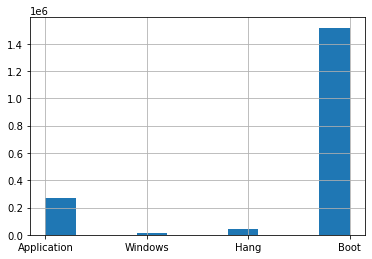

In [374]:
df['error_type'].hist()

In [375]:
print(df.shape)
df.dtypes

(1835089, 173)


level_0                                   int64
index                                   float64
RWB_EVENTRAWRESULTITEM_ID               float64
RWB_ETL_EVENT_DESTINATION_IDENTIFIER      int64
RWB_CREATE_TIMESTAMP                     object
                                         ...   
MachineName                              object
Reason                                   object
param5                                   object
ActionDescription                        object
BootID_formatted                         object
Length: 173, dtype: object

In [376]:
# How many boot events occurred after an INC was filed?
# df[df['error_type'] == 'Boot']['BootID'] - df[df['error_type'] == 'Boot']['opened_at_cst_not_utc']


# Create 'num_events' feature.


In [377]:
'CreatedSystemTime_CST_formatted' in list(df.columns)

True

In [378]:
# Because 'TimeCreatedSystemTime' never exists in 'df_boot',
# 'CreatedSystemTime_CST_formatted' will always be pd.NaT for Boot events,
# because it is unique to the regular events only.
df[df['error_type'] == 'Boot']['CreatedSystemTime_CST'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns, America/Chicago]

In [379]:
# Create the events feature by grouping by ClientItemKey and the TimeCreatedSystemTime CST date column,
# and get the count of events for each machine each day.
# Boot events excluded by default on basis of the .groupby() columns.

# num_events = df.groupby(['RWB_EFFECTIVE_DATE', 'ClientItemKey']).agg('size').reset_index().rename(columns={0:'events'})
num_events = df[df['error_type'] != 'Boot'].groupby(['ClientItemKey', 'CreatedSystemTime_CST_formatted']).agg('size').reset_index().rename(columns={0:'events'})
num_events

,ClientItemKey,CreatedSystemTime_CST_formatted,events
0,16783564,2023-03-13,1
1,16783564,2023-04-03,2
2,16783835,2023-01-10,1
3,16783835,2023-01-20,1
4,16783835,2023-02-10,1
...,...,...,...
188461,16819018,2023-05-15,1
188462,16819018,2023-06-28,1
188463,16819018,2023-06-30,3
188464,16819021,2023-06-30,1


<AxesSubplot:>

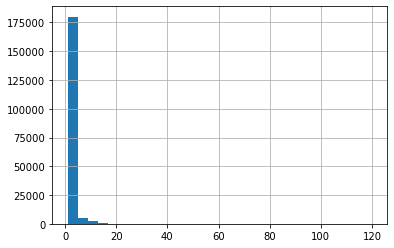

In [380]:
num_events['events'].hist(bins=30)

In [381]:
check_this_df = pd.read_parquet('../do_not_commit/FeatureDatasets/num_events.pq')
print(check_this_df['events'].sum())
check_this_df

317218


In [382]:
# Export the result to parquet and save to blob storage.
num_events.to_parquet('../do_not_commit/FeatureDatasets/num_events.pq')


# Create 'num_events_incs' feature.


In [383]:
# 'opened_at_formatted' was wiped for all events (rows) after an INC was filed on same day
# in the join machines + events + incs section. If no value exists for any events
# after an INC was filed, subsetting with .notnull() should give us what we need.

num_events_inc = df[
    (df['error_type'] != 'Boot') &
    (df['opened_at_formatted'].notnull())
].groupby(['ClientItemKey', 'CreatedSystemTime_CST_formatted']).agg('size').reset_index().rename(columns={0:'events'})
num_events_inc

,ClientItemKey,CreatedSystemTime_CST_formatted,events
0,16787905,2023-01-23,2
1,16787905,2023-05-01,1
2,16787935,2023-03-06,2
3,16787935,2023-03-30,1
4,16787935,2023-06-06,1
...,...,...,...
1903,16818798,2023-06-27,1
1904,16818818,2023-06-20,1
1905,16818828,2023-06-27,1
1906,16818878,2023-06-27,3


In [384]:
# 'CreatedSystemTime_CST' is in CST, 'opened_at' is in UTC, a difference of 6 hours.
df[(df['ClientItemKey'] == 16790461) & (df['CreatedSystemTime_CST_formatted'] == '2023-02-22')][['CreatedSystemTime_CST', 'opened_at']]

,CreatedSystemTime_CST,opened_at
288909,2023-02-22 15:10:37.167000-06:00,2023-02-22 21:31:00
288910,2023-02-22 15:11:38.777000-06:00,2023-02-22 21:31:00
288911,2023-02-22 15:12:22.523000-06:00,2023-02-22 21:31:00
288912,2023-02-22 15:12:47.290000-06:00,2023-02-22 21:31:00
288913,2023-02-22 15:16:09.427000-06:00,2023-02-22 21:31:00
288914,2023-02-22 15:24:32.457000-06:00,2023-02-22 21:31:00
288915,2023-02-22 15:29:28.760000-06:00,2023-02-22 21:31:00
288916,2023-02-22 15:31:15.080000-06:00,2023-02-22 21:31:00
288917,2023-02-22 15:36:11.057000-06:00,2023-02-22 21:31:00
288918,2023-02-22 15:36:30.607000-06:00,2023-02-22 21:31:00


<AxesSubplot:>

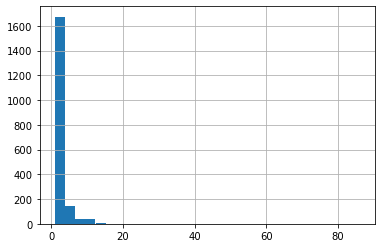

In [385]:
num_events_inc['events'].hist(bins=30)

In [386]:
check_this_df = pd.read_parquet('../do_not_commit/FeatureDatasets/num_events_inc.pq')
print(check_this_df['events'].sum())
check_this_df

4494


,ClientItemKey,CreatedSystemTime_CST_formatted,events
0,16787905,2023-01-23,2
1,16787905,2023-05-01,1
2,16787935,2023-03-06,2
3,16787935,2023-03-30,1
4,16787935,2023-06-06,1
...,...,...,...
1903,16818798,2023-06-27,1
1904,16818818,2023-06-20,1
1905,16818828,2023-06-27,1
1906,16818878,2023-06-27,3


In [387]:
# Export the result to parquet and save to blob storage.
num_events_inc.to_parquet('../do_not_commit/FeatureDatasets/num_events_inc.pq')


#### How many INCs contain direct reference to BSOD?


In [388]:
df['short_description_NER'].unique()

array([nan, 'URGENT| Repeated Blue Screen of Death', None, ...,
       "Computer was n't working", 'Fidessa + TradeWeb install',
       'Thomson One / Start menu unresponsive in Citrix'], dtype=object)

In [389]:
# How many short descriptions talk about BSODs?
len(df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

62

<AxesSubplot:>

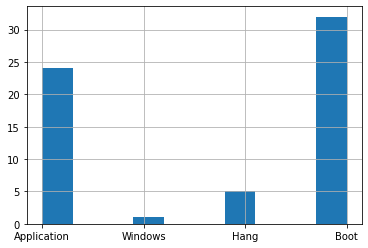

In [390]:
# What is the frequency of each error type for BSOD tickets?
df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [391]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'Combined_Application', 'Combined_dll', 'Combined_Exception']]

,error_type,Combined_Application,Combined_dll,Combined_Exception
74,Application,powershell.exe,BIOSIntf.dll,c0000005
9237,Application,powershell.exe,BIOSIntf.dll,c0000005
25428,Application,powershell.exe,BIOSIntf.dll,c0000005
40784,Application,IntelAudioService.exe,ControlModule.dll,c0000005
46501,Application,powershell.exe,BIOSIntf.dll,c0000005
...,...,...,...,...
1775603,Boot,NaN,NaN,0x0
1794407,Boot,NaN,NaN,0x0
1797687,Boot,NaN,NaN,0x0
1806773,Boot,NaN,NaN,0x0


In [392]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']

/tmp/ipykernel_13369/1312422880.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']


74                          powershell.exe
9237                        powershell.exe
25428                       powershell.exe
40784                IntelAudioService.exe
46501                       powershell.exe
47697                       powershell.exe
48187                 RtkAudUService64.exe
51341                          OUTLOOK.EXE
64927                       powershell.exe
68205                              dwm.exe
75252                       powershell.exe
81591                IntelAudioService.exe
83756                       powershell.exe
84440                       powershell.exe
89599                       WavesSvc64.exe
89952                       powershell.exe
93779     svchost.exe_BrokerInfrastructure
97864                       powershell.exe
108639                      powershell.exe
113451                      powershell.exe
145464                RtkAudUService64.exe
183199                      powershell.exe
221248                      powershell.exe
267120     

In [393]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']

/tmp/ipykernel_13369/4070623319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']


374952                              BSOD- No stop code error
461611                                                  BSOD
474646                                                  BSOD
482939                  Plugging in headphones prompted BSOD
1165139    BSOD at Startup- Stop Code WHEA- uncorrectable...
1176000    Received the blue screen of death <CARDINAL> t...
1179787                                                 BSOD
1207184                             Laptop BSOD'd 5/10/20223
1218035    Laptop Overheating, Blue Screen Crashing- Unit...
1223350    Repeated Blue Screen Error: Device did not sta...
1236559    BSOD at Startup- Get stuck at Dell logo before...
1241536                        Blue Screen Crashes on laptop
1241659                  Laptop Blue Screening Every Morning
1262377                                        BSOD- Startup
1266596                                Laptop BSOD on U30366
1267463               BSOD- Device did not startup correctly
1275289                 


#### What is the distribution of FaultApplicationName among INCs?


In [394]:
df_check = df[df['error_type'] == 'Application']

In [395]:
df_check['Combined_Application'].value_counts()

powershell.exe          69017
EXCEL.EXE               21941
Acrobat.exe             20938
WavesSvc64.exe          14684
RtkAudUService64.exe    13580
                        ...  
svchost.exe_UsoSvc          1
Upfc.exe                    1
RaptorExporter.exe          1
NWMSysDialog.exe            1
EikonBoxNet.exe             1
Name: Combined_Application, Length: 736, dtype: int64


#### What is the distribution of modules among INCs?


In [396]:
df_check['Combined_dll'].value_counts()

BIOSIntf.dll            68893
KERNELBASE.dll          42027
ntdll.dll               24195
WavesSvc64.exe          14631
RtkAudUService64.exe    13449
                        ...  
r_wrsfmkja.dll              1
w_wobvwihq.dll              1
m_omqxqggo.dll              1
u_wwxgcujv.dll              1
u_lwawedzn.dll              1
Name: Combined_dll, Length: 18061, dtype: int64


#### Which exception codes are most common among INCs?


In [397]:
df_check[['Combined_Application', 'Combined_Exception']].value_counts()

Combined_Application       Combined_Exception
powershell.exe             c0000005              68899
WavesSvc64.exe             c0000005              14663
RtkAudUService64.exe       c0000005              13466
Acrobat.exe                c0000005               9437
                           e06d7363               9315
                                                 ...  
SSFolderPrev.exe           c0000005                  1
SSHPdf2Jpg.exe             c0000094                  1
SSMS-Setup-ENU.exe         c00000fd                  1
Sage.NA.AT_AU.SysTray.exe  c000041d                  1
zt.exe                     c0000005                  1
Length: 1702, dtype: int64